## `imports` (don't read, just run)

In [1]:
from IPython import get_ipython

ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import copy
import time
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
import pyperclip
from IPython.display import HTML, SVG, Image, clear_output, display
from PIL import Image as PILImage
from tqdm import tqdm

import instructions
from image_color import Img, ThreadArtColorParams

In [2]:
# https://drive.google.com/drive/folders/1WwnPifrnYRCLY2bVhGsLiTsAWFLgSHZM
# path = r"C:\Users\calsm\Documents\ComputationalArt\computational-thread-art-v3\images\df_color_070"
path = Path(__vsc_ipynb_file__).parent / "images/df_color_070"
assert path.exists()

df = pd.read_pickle(str(path))

# df.head()
df[df.name.str.contains("stag")].head()

,name,x,n_nodes,filename,palette,n_lines_per_color,n_random_lines,darkness,blur_rad,group_orders,line_width_multiplier,w_filename
15,stag,760,500,stag.jpg,"[[255, 255, 255], [0, 120, 240], [0, 0, 120], ...","[3600, 700, 7000, 2300, 9000]",160,0.16,4,5,1.5,
33,stag_large,1600,800,stag_large_6.jpg,"[[255, 255, 255], [0, 215, 225], [0, 120, 240]...","[1717, 1050, 715, 3148, 6870]",150,0.18,8,wwwwdbwwwwdmmmccbwwwdmmmccbwwddmmcwbmb,1.5,
42,stag_sq,800,380,stag_large_square.jpg,"[[255, 255, 255], [0, 215, 225], [0, 120, 240]...","[1000, 1100, 450, 2000, 2400]",150,0.12,8,wwwwwwmmmccbwwwnnmmmccbwwnnmmb,1.5,


In [3]:
width_per_img = 600
n_cols = 6

output_path = Path(__vsc_ipynb_file__).parent / "outputs"

images = []
n_lines = []

for output_dir in tqdm(list(output_path.iterdir())):
    if output_dir.is_dir() and "0.1" in output_dir.name:
        img_file = output_dir / f"{output_dir.name}.png"
        svg_file = output_dir / f"{output_dir.name}.svg"
        assert img_file.exists()
        assert svg_file.exists()

        # Load in the image, and get it as a numpy array
        with PILImage.open(img_file) as im:
            img = im.resize((width_per_img, int(im.size[1] * width_per_img / im.size[0])))
            img = np.array(img)

        # Load in the SVG text and count the number of lines, concat this to the image name
        with open(svg_file, "r") as f:
            svg_text = f.read()
        n_lines = svg_text.count(" M ")
        name = f"{output_dir.name} ({n_lines} lines)"

        images.append((name, img))

# Sort images by aspect ratio
images = sorted(images, key=lambda x: x[1].shape[0] / x[1].shape[1])

# Get height cumsum, get the cutoff points for each column, and use them to make our columns
image_cols = []
name_cols = []
heights = [img.shape[0] for _, img in images]
heights_cumsum = np.cumsum(heights)
cutoff_idx_start = 0
for i in range(1, n_cols + 1):
    target_height = (i / n_cols) * heights_cumsum[-1]
    cutoff_idx_end = np.abs(heights_cumsum - target_height).argmin()
    col_images = images[cutoff_idx_start:cutoff_idx_end]
    img = np.concatenate([img[1] for img in col_images], axis=0)
    image_cols.append(img)
    name_cols.append(
        np.concatenate(
            [np.array(img[0]).repeat(img[1][..., 0].size).reshape(img[1].shape[:-1]) for img in col_images], axis=0
        )
    )
    cutoff_idx_start = cutoff_idx_end

max_height = max([img.shape[0] for img in image_cols])
final_img = np.zeros((max_height, width_per_img * n_cols, 3), dtype=np.uint8)
name_img = np.zeros((max_height, width_per_img * n_cols), dtype=object)
for i, (img_col, name_col) in enumerate(zip(image_cols, name_cols)):
    final_img[: img_col.shape[0], i * width_per_img : (i + 1) * width_per_img, :] = img_col
    name_img[: img_col.shape[0], i * width_per_img : (i + 1) * width_per_img] = name_col

px.imshow(final_img).update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    plot_bgcolor="rgba(0, 0, 0, 0)",
    paper_bgcolor="rgba(0, 0, 0, 0)",
    width=1800,
    height=1800,
).update_xaxes(showticklabels=False).update_yaxes(showticklabels=False).update(
    data=[{"customdata": name_img, "hovertemplate": "%{customdata}<br>%{z}"}]
).show(config={"displayModeBar": False})  # "staticPlot": True

100%|██████████| 38/38 [00:00<00:00, 18924.67it/s]


IndexError: index -1 is out of bounds for axis 0 with size 0

## `guide` (for reference)

### Making physical pieces

- Stretch >=4 threads across and see where they intersect, to get the coords of the center
- Zero the gantry at that center
- Put a piece of tape on hook zero (i.e. the one facing right - make sure the big wheel hole is at the top)
- Move the gantry between the red hook 0 and hook 1 (at the radius where the hook ends, i.e. you need to go at least
    that far to loop around it) and get the (x, y) coordinates at that point
- Generate a list of strings with the `generate_thread_art_gcode` function (passing in the starting coords)
- The first list is one that will move to a pre-selected bunch of nodes, then move through them, just as practice
- Then do all subsequent ones!
- How to swap over colors? 
    - Start by winding the thread around a hook (doesn't really matter which one we start with)
    - When you swap over colors, cut the old one off & tie it to the new one to pull it through the pipette
    - Take the old one and wind it around its last hook, and attach a clip to it for identification
    - Tie the new one to the old one (should tie it to itself not to the new thread, for tightest knot)

### Parameters

The red bus below is a good starting point, although here are some adjustments I'd make from it:

- Thread count? Think this was about right, shouldn't be much less than this but doesn't need to be any more
- Darkness? I overshot the black (and had 2/3 on the outer layer), need more groups (e.g. 1/3 black on top)
- Spacing? I used `4 * 36` hooks for `288` nodes; the algorithm was fine with this so I should aim for around 240-280

### 

## `debugging`

In [ ]:
from coordinates import build_through_pixels_dict

x = 400
y = 200
n_nodes = 200
shape = "Rectangle"
critical_fracs = (0.25, 0.25)

d_coords, d_joined, _, _ = build_through_pixels_dict(x, y, n_nodes, shape, critical_fracs, debug=True)

In [ ]:
from coordinates import build_through_pixels_dict

x = 200
y = 200
n_nodes = 200
shape = "Ellipse"
critical_fracs = (0.2, 0.2)

d_coords, d_joined, _, _ = build_through_pixels_dict(x, y, n_nodes, shape, critical_fracs, debug=True)

## `demos` status

- `1` - animals (gone through once, but not with `DEFAULT_PAINT_REALISTIC`)
- `2` - London
- `3` - space & sky
- `4` - misc

Progression into fewer-line improved pieces: Finished `1.0` and `1.1`

In [4]:
DEFAULT_PHYSICAL_ARGS = dict(
    n_nodes=5 * 32 * 2,
    blur_rad=4,
    # ^ Not really sure what effect changing this has
    # critical_fracs=(0.2, 0.075),
    critical_fracs=(0.18, 0.07),
    # ^ I used (0.23, 0.09) for the London bus and it was basically fine for gantry, no major issues
    critical_frac_penalty_power_decay=0.3,  # 0.3 > 0.5 > None in terms of how it looks
    # Don't think I need to use the power decay for it to look okay.
    width_to_gap_ratio=4 / 6,
)

DEFAULT_DRAW_ARGS = dict(
    n_nodes=320,
    blur_rad=4,
    # ^ Not really sure what effect changing this has
    critical_fracs=(0.03, 0.03),
    critical_frac_penalty_power_decay=0.3,
    # Don't think I need to use the power decay for it to look okay.
    width_to_gap_ratio=1.0,
)

DEFAULT_PHYSICAL_ARGS_RECTANGLE = dict(
    n_nodes=420,
    blur_rad=4,
    critical_fracs=(0.14, 0.07),
    critical_frac_penalty_power_decay=None,
    width_to_gap_ratio=4 / 6,
)

DEFAULT_DRAWING_ARGS = dict(
    n_nodes=320,
    blur_rad=2,
    # ^ Not really sure what effect changing this has
    critical_fracs=(0.03, 0.03),
    critical_frac_penalty_power_decay=None,
)

DEFAULT_PAINT_REALISTIC = dict(
    line_width_multiplier=1.5,
    html_line_width_multiplier=1.5,
    html_bg_color=(180, 180, 180),
    inner_background_color=(180, 180, 180),
    background_color=(255, 255, 255),
    rand_perm=0.002,
)

DEFAULT_DRAW_REALISTIC = dict(
    line_width_multiplier=1.8,
    html_line_width_multiplier=1.8,
    # background_color=(255, 255, 255),
    # background_color=(245, 245, 220),
    background_color=None,
    rand_perm=0.002,
)

### `1.0` Stag

In [ ]:
kwargs = dict(
    name="stag_01",
    x=1600,
    filename="stag-large.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (0, 215, 225),  # light_blue
        (0, 120, 240),  # mid_blue
        (0, 0, 120),  # dark_blue
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[1300, 800, 750, 2450, 5400],
    shape="Rectangle",
    n_random_lines=100,
    darkness=[0.16, 0.16, 0.12, 0.14, 0.12],
    blur_rad=4,
    group_orders="1,1,2,3,4,5,1,2,2,3,4,1,3,5",
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS_RECTANGLE, **kwargs})
MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
    show_individual_colors=True,
    verbose=False,
    make_html=True,
    x_output=900,
    html_x=800,
    html_x_small=330,
    html_line_width_multiplier=0.9,
    html_total_slider_steps=200,
    html_rand_perm=0.002,
    html_bg_color=(0, 0, 0),
)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
kwargs = dict(
    name="stag_02_large",
    x=1700,
    filename="stag.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (0, 215, 225),  # light_blue
        (0, 120, 240),  # mid_blue
        (0, 0, 120),  # dark_blue
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[1800, 1000, 750, 3400, 8400],
    shape="Rectangle",
    n_random_lines=250,
    darkness=[0.15, 0.14, 0.10, 0.11, 0.11],
    blur_rad=4,
    group_orders="1,4,2,5,1,4,3,2,5,1,4,3,2,1,5,3,5",
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS_RECTANGLE, **kwargs})
MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
    show_individual_colors=True,
    verbose=False,
    make_html=True,
    line_width_multiplier=0.7,
    x_output=900,
    html_x=800,
    html_x_small=330,
    html_line_width_multiplier=0.9,
    # html_total_slider_steps=200,
    html_rand_perm=0.002,
    html_bg_color=(0, 0, 0),
    html_color_names=["white", "light blue", "mid blue", "dark blue", "black"],
)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
kwargs = dict(
    name="stag_sq_01",
    x=1200,
    filename="stag_sq.jpg",
    # w_filename=None,
    w_filename="stag_sq_w.jpg",
    palette=[
        (255, 255, 255),  # white
        (0, 215, 225),  # light_blue
        (0, 120, 240),  # mid_blue
        (0, 0, 120),  # dark_blue
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[1200, 650, 500, 1500, 2300],
    shape="Circle",
    n_random_lines=150,
    darkness=[0.16, 0.15, 0.12, 0.14, 0.14],
    group_orders="1,2,3,4,5,1,2,3,4,5,5",
    width_to_gap_ratio=4 / 6,
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS, **kwargs})
MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
    # line_width_multiplier=0.7,
    x_output=900,
    html_x=800,
    html_bg_color=(0, 0, 0),
    inner_background_color=(0, 0, 0),
    background_color=(255, 252, 235),
    html_color_names=["white", "light blue", "mid blue", "dark blue", "black"],
)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `1.1` Tiger

In [ ]:
kwargs = dict(
    name="tiger_01",
    x=1000,
    filename="tiger.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (255, 130, 0),  # orange
        (255, 0, 0),  # red
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[2500, 2000, 700, 4500],
    shape="Rectangle",
    n_random_lines=150,
    darkness=[0.19, 0.17, 0.17, 0.17],
    group_orders="1,2,3,3,4,4,1,2,2,3,4",
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS, **kwargs})
MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
    x_output=800,
    show_individual_colors=True,
    make_html=True,
    html_line_width_multiplier=1.2,
    html_x=800,
)

clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
kwargs = dict(
    name="tiger_sq_01",
    x=1200,
    filename="tiger_sq_expanded.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (255, 130, 0),  # orange
        (255, 0, 0),  # red
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[1500, 1500, 400, 2400],
    shape="Ellipse",
    n_random_lines=150,
    darkness=[0.20, 0.20, 0.20, 0.20],
    blur_rad=4,
    group_orders="2,3,4,1,2,3,4,4",
)

args = ThreadArtColorParams(**DEFAULT_PHYSICAL_ARGS, **kwargs)
MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
    show_individual_colors=True,
    # line_width_multiplier=0.8,
    html_color_names=["white", "orange", "red", "black"],
    x_output=700,
    inner_background_color=(0, 0, 0),
    background_color=(255, 252, 235),
)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
kwargs = dict(
    name="tigereye_01",
    x=1500,
    filename="tigereye.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (250, 130, 0),  # orange
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[3200, 2200, 4800],
    shape="Rectangle",
    n_random_lines=150,
    darkness=[0.19, 0.21, 0.21],
    group_orders="1,2,3,1,2,3",
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS, **kwargs})
MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=800)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `1.2` Leopard

In [ ]:
kwargs = dict(
    name="leopard_01",
    x=800,
    filename="leopard.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (255, 160, 0),  # orange
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[3600, 1500, 5000],
    shape="Rectangle",
    n_random_lines=120,
    darkness=[0.11, 0.12, 0.11],
    other_colors_weighting=[
        [1.0, -0.2, 0.0],
        [-0.2, 1.0, 0.0],
        [0.0, 0.0, 1.0],
    ],
    group_orders="1,1,2,3,3,1,2,3",
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS_RECTANGLE, **kwargs})
MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=800)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
kwargs = dict(
    name="leopard_sq_01",
    x=800,
    filename="leopard_sq_upscaled_2.png",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (255, 160, 0),  # orange
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[1800, 900, 3200],
    shape="Ellipse",
    n_random_lines=120,
    darkness=[0.13, 0.12, 0.12],
    other_colors_weighting=[
        [1.0, -0.2, 0.0],
        [-0.2, 1.0, 0.0],
        [0.0, 0.0, 1.0],
    ],
    group_orders="1,2,3,3,3,1,2,3,3",
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS, **kwargs})
MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=800)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `1.3` Lion

In [ ]:
kwargs = dict(
    name="lion_01",
    x=750,
    filename="lion.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (255, 150, 0),  # orange
        (255, 0, 0),  # red
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[1800, 4500, 1400, 4800],
    shape="Rectangle",
    n_random_lines=150,
    darkness=[0.12, 0.09, 0.12, 0.12],
    group_orders="1,2,3,4,1,2,3,4",
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS_RECTANGLE, **kwargs})
MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=800)

clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
# All same, but lower darkness

kwargs = dict(
    name="lion_sq_01",
    x=750,
    filename="lion_sq.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (255, 150, 0),  # orange
        (255, 0, 0),  # red
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[950, 2400, 800, 2800],
    shape="Ellipse",
    n_random_lines=150,
    darkness=[0.13, 0.12, 0.13, 0.11],
    group_orders="1,2,3,4,1,2,3,4",
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS_RECTANGLE, **kwargs})

MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, inner_background_color=(0, 0, 0), background_color=(255, 252, 235))

clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `1.4` Duck

In [ ]:
kwargs = dict(
    name="duck_01",
    x=800,
    n_nodes=500,
    filename="duck.jpg",
    w_filename="duck_importance_weighting.jpg",
    palette=[
        (255, 255, 255),  # white
        (255, 255, 0),  # yellow
        (255, 0, 0),  # red
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[1800, 1600, 700, 7200],
    shape="Rectangle",
    n_random_lines=120,
    darkness=[0.12, 0.10, 0.12, 0.12],
    other_colors_weighting=[
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0],
        [-0.3, 0.0, 0.0, 1.0],
    ],
    group_orders="1,1,2,3,4,1,2,3,4,4",
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS_RECTANGLE, **kwargs})
MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
    show_individual_colors=True,
    x_output=750,
    html_x=750,
    html_line_width_multiplier=0.9,
    html_color_names=["white", "yellow", "red", "black"],
)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
kwargs = dict(
    name="duck_sq_01",
    x=800,
    filename="duck_sq.jpg",
    # w_filename="duck_sq_importance_weighting.jpg",
    w_filename="duck_sq_w.jpg",
    # w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (255, 255, 0),  # yellow
        (255, 0, 0),  # red
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[900, 1000, 450, 4500],
    shape="Ellipse",
    n_random_lines=120,
    darkness=[0.12, 0.10, 0.13, 0.12],
    other_colors_weighting=[
        [1.0, 0.0, 0.0, 0.0],
        [-0.1, 1.0, 0.0, 0.0],
        [-0.1, 0.0, 1.0, 0.0],
        [-0.3, 0.0, 0.0, 1.0],
    ],
    group_orders="1,1,2,3,4,1,2,3,4,4",
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS, **kwargs})
MyImg = Img(args)
# MyImg.decompose_image()
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
    show_individual_colors=True,
    x_output=750,
    html_x=750,
    html_line_width_multiplier=0.9,
    html_color_names=["white", "yellow", "red", "black"],
)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `1.5` Fish

In [ ]:
kwargs = dict(
    name="fish_sq_01",
    x=1500,
    filename="fish_sq.jpg",
    w_filename="fish_sq_w.jpg",
    palette=[
        (255, 255, 255),  # white
        (255, 100, 0),  # orange
        (50, 150, 220),  # mid_blue
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[400, 1200, 1300, 2900],
    other_colors_weighting=[  # I want less black & blue in fish body
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0],
        [-0.15, 0.0, 1.0, 0.0],
        [-0.10, 0.0, 0.0, 1.0],
    ],
    shape="Ellipse",
    n_random_lines=150,
    darkness=[0.33, 0.23, 0.30, 0.24],
    group_orders="2,2,3,1,4,2,3,4,4",
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS, **kwargs})

MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=800, html_x=800)

clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
kwargs = dict(
    name="fish_01",
    x=1500,
    filename="fish.jpg",
    w_filename="fish_w.jpg",
    palette=[
        (255, 255, 255),  # white
        (255, 100, 0),  # orange
        (50, 150, 220),  # mid_blue
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[400, 1900, 2700, 4000],
    other_colors_weighting=[  # I want less black & blue in fish body
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0],
        [-0.15, 0.0, 1.0, 0.0],
        [-0.10, 0.0, 0.0, 1.0],
    ],
    shape="Rectangle",
    n_random_lines=200,
    darkness=[0.28, 0.24, 0.28, 0.25],
    blur_rad=4,
    group_orders="1,1,2,2,3,4,1,2,3,4,4",
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS_RECTANGLE, **kwargs})

MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=900, html_x=1000)

clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `1.6` Snake

In [ ]:
kwargs = dict(
    name="snake_01",
    x=1400,
    filename="snake.png",
    w_filename="snake_w2.png",
    palette=[
        (255, 255, 255),  # white
        (255, 255, 0),  # yellow
        (255, 0, 0),  # red
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[1300, 1200, 1200, 8000],
    # other_colors_weighting=dict(
    #     # white=dict(yellow=0.2, red=0.2, black=-0.05),
    #     # yellow=dict(red=0.2, white=0.2, black=-0.05),
    #     # red=dict(yellow=0.2, white=0.2, black=-0.05),
    #     black={"*": 0.1}
    # ),
    n_random_lines=150,
    shape="Rectangle",
    darkness=[0.12, 0.10, 0.12, 0.14],
    # group_orders="1,1,2,2,3,3,4,1,2,3,4,1,2,3,4,1,2,3,4,4,4",
    group_orders="1,1,2,2,3,3,4,1,2,3,4,4",
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS_RECTANGLE, **kwargs})
MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=900, html_x=1100)

clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `1.7` Phoenix

In [ ]:
kwargs = dict(
    name="phoenix_01",
    x=800,
    filename="phoenix.jpg",
    w_filename=None,
    palette=[
        (255, 162, 0),  # yellow
        (255, 0, 0),  # red
        (0, 145, 255),  # light_blue
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[1600, 1100, 2400, 4200],
    shape="Rectangle",
    n_random_lines=200,
    darkness=[0.23, 0.23, 0.23, 0.23],
    blur_rad=4,
    group_orders="3,2,1,4,4,3,3,2,1,4",
)
# df[df.name.str.contains("phoenix")].head()

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS_RECTANGLE, **kwargs})

MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict)

clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
kwargs = dict(
    name="phoenix_sq_01",
    x=750,
    filename="phoenix_sq2.jpg",
    w_filename=None,
    palette=[
        (255, 162, 0),  # yellow
        (255, 0, 0),  # red
        (0, 145, 255),  # light_blue
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[1250, 850, 1300, 2450],
    shape="Ellipse",
    n_random_lines=120,
    darkness=[0.17, 0.19, 0.15, 0.19],
    blur_rad=4,
    group_orders="3,2,1,4,4,3,3,2,1,4",
)
# df[df.name.str.contains("phoenix")].head()

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS, **kwargs})

MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
    inner_background_color=(0, 0, 0),
    background_color=(255, 252, 235),
)

clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

###

---

### `2.0` London: Union Jack

In [ ]:
kwargs = dict(
    name="london_union_jack_01",
    x=600,
    filename="union_jack_sq_2.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (255, 0, 0),  # red
        (0, 120, 240),  # blue
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[2300, 2200, 1100, 2000],
    other_colors_weighting=[  # red/white should avoid each other, same for white/blue
        [1.0, -0.15, -0.15, 0.0],
        [-0.15, 1.0, 0.0, 0.0],
        [-0.15, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0],
    ],
    shape="Ellipse",
    n_random_lines=120,
    darkness=[0.11, 0.11, 0.10, 0.12],
    blur_rad=4,
    group_orders="1,2,3,1,2,3,4,3,2,4",
)

args = ThreadArtColorParams.from_dict(DEFAULT_PHYSICAL_ARGS | kwargs)
MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)

line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
    # line_width_multiplier=1.1,
    html_bg_color=(0, 0, 0),
    inner_background_color=(0, 0, 0),
    # background_color=(255, 252, 235),
    background_color=(255, 255, 255),
)
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
kwargs = dict(
    name="london_union_jack_02_small",
    x=420,
    n_nodes=180,
    filename="union_jack_sq_2.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (255, 0, 0),  # red
        (0, 120, 240),  # blue
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[1100, 950, 480, 950],
    other_colors_weighting=[  # red/white should avoid each other, same for white/blue
        [1.0, -0.15, -0.15, 0.0],
        [-0.15, 1.0, 0.0, 0.0],
        [-0.15, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0],
    ],
    shape="Ellipse",
    n_random_lines=120,
    darkness=[0.11, 0.11, 0.10, 0.12],
    blur_rad=4,
    group_orders="1,2,3,4,1,2,3,4",
)

args = ThreadArtColorParams.from_dict(DEFAULT_PHYSICAL_ARGS | kwargs)
MyImg = Img(args)

line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
    line_width_multiplier=1.3,
    html_bg_color=(0, 0, 0),
    inner_background_color=(0, 0, 0),
    background_color=(255, 252, 235),
    html_line_width_multiplier=1.3,
    rand_perm=0.005,
    # fraction={
    #     (255, 255, 255): (0, 0.9),
    #     (255, 0, 0): (0, 0.9),  # red
    #     (0, 120, 240): (0, 0.9),  # blue
    #     (0, 0, 0): (0, 0.9),  # black
    # },
)
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(data=f.read()))

### `2.1` London Bus

In [ ]:
kwargs = dict(
    name="london_bus_01",
    x=700,
    filename="london_bus_4_exp.jpg",  # _2 has no red bus in bg, maybe better? ask someone
    w_filename="london_bus_w2_exp.jpg",
    palette=[
        (255, 255, 255),  # white
        (255, 0, 0),  # red
        (0, 0, 0),  # black
    ],
    # n_lines_per_color=[2000, 1400, 3700],
    n_lines_per_color=[1400, 1200, 2400],
    shape="Ellipse",
    n_random_lines=120,
    darkness=[0.16, 0.12, 0.13],
    blur_rad=4,
    group_orders="2,1,2,3,1,2,3,3",
    neg_penalty_multiplier=0.4,
)

args = ThreadArtColorParams.from_dict(DEFAULT_PHYSICAL_ARGS | kwargs)
MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, **DEFAULT_PAINT_REALISTIC)
clear_output()
# with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
#     display(Image(f.read()))

# instructions_html = MyImg.generate_thread_art_instructions_html(line_dict)
# with open(f"outputs/{args.name}/instructions-{args.name}.html", "w") as f:
#     f.write(instructions_html)

In [ ]:
kwargs = dict(
    name="london_bus_02_zoomed_in",
    x=700,
    filename="london_bus_6.jpg",
    w_filename="london_bus_w2.jpg",
    palette=[
        (255, 255, 255),  # white
        (255, 0, 0),  # red
        (0, 0, 0),  # black
    ],
    # n_lines_per_color=[2000, 1400, 3700],
    n_lines_per_color=[1400, 1250, 2700],
    shape="Ellipse",
    n_random_lines=120,
    darkness=[0.16, 0.12, 0.12],
    blur_rad=4,
    group_orders="2,1,2,3,1,2,3,3",
    neg_penalty_multiplier=0.4,
)

args = ThreadArtColorParams.from_dict(DEFAULT_PHYSICAL_ARGS | kwargs)
MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, **DEFAULT_PAINT_REALISTIC)
clear_output()
# with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
#     display(Image(f.read()))

# instructions_html = MyImg.generate_thread_art_instructions_html(line_dict)
# with open(f"outputs/{args.name}/instructions-{args.name}.html", "w") as f:
#     f.write(instructions_html)

In [ ]:
gcode = instructions.generate_thread_art_gcode(
    line_dict=line_dict,
    n_nodes=args.n_nodes,
    group_orders=args.group_orders,
    starting_posn=(-208.0, -15.3),
    debug_nodes=[i * 16 for i in range(0, 18, 3)],
    feed_rate=12_500,  # 12.5k
    arc_feed_rate=10_000,  # 10k
    inner_radius=10,
    outer_radius=0,
    test_distance=0,
)
# del gcode[1]
# print([len(x) for x in gcode])
assert len(gcode) - len(args.group_orders.split(",")) == 1

for color, code in zip(["0"] + args.group_orders.split(","), gcode, strict=True):
    print(f"{color} | {len(code)} lines")

n_left = 7542
# pyperclip.copy("\n".join((gcode[-2] + gcode[-1])[-n_left + 20 : -n_left + 30]))
pyperclip.copy("\n".join(gcode[-1]))

#  just finished the first black lines group
# might need to bend some hooks on the red tape side, but overall looking good!

# 10 minutes for 1000 lines

In [ ]:
kwargs = dict(
    name="london_bus_03_draw",
    x=700,
    filename="london_bus_4_exp.jpg",
    w_filename="london_bus_w2_exp.jpg",
    palette=[
        (255, 255, 255),  # white
        (255, 0, 0),  # red
        (0, 0, 0),  # black
    ],
    # n_lines_per_color=[2000, 1400, 3700],
    n_lines_per_color=[1, 750, 1650],
    shape="Ellipse",
    n_random_lines=120,
    darkness=[0.16, 0.14, 0.18],
    group_orders="2,3",
    neg_penalty_multiplier=0.4,
)

args = ThreadArtColorParams.from_dict(DEFAULT_DRAW_ARGS | kwargs)
MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=800, **DEFAULT_DRAW_REALISTIC)
clear_output()
# with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
#     display(Image(f.read()))

# instructions_html = MyImg.generate_thread_art_instructions_html(line_dict)
# with open(f"outputs/{args.name}/instructions-{args.name}.html", "w") as f:
#     f.write(instructions_html)

### `2.2` London Eye

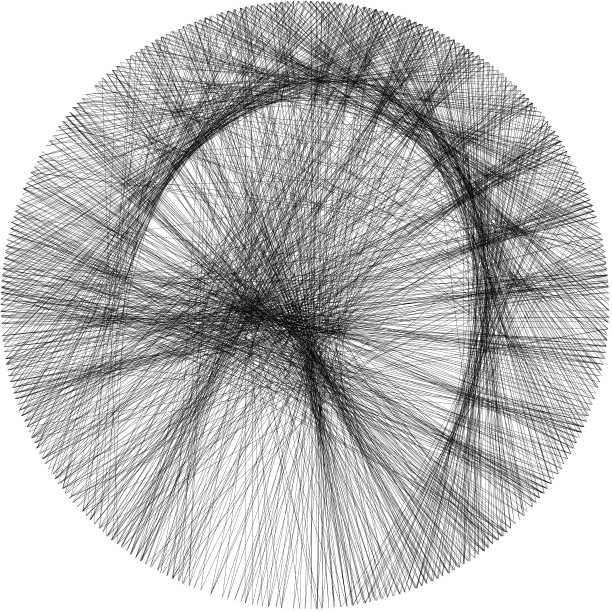

In [11]:
kwargs = dict(
    name="london_eye_02_draw",
    x=612,
    filename="london_eye_3a1.jpg",
    w_filename=None,
    n_lines_per_color=1050,
    shape="Ellipse",
    n_random_lines=180,
    darkness=0.08,
    neg_penalty_multiplier=0.9,
    group_orders="1,2",
    mode="monochrome-draw",
)

args = ThreadArtColorParams.from_dict(DEFAULT_DRAW_ARGS | kwargs)
MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)
clear_output()

line_dict = MyImg.create_canvas()

# MyImg.paint_canvas(
#     line_dict,
#     line_width_multiplier=1.1,
#     html_bg_color=(255, 255, 255),
#     inner_background_color=(255, 255, 255),
#     background_color=(255, 255, 255),
# )
MyImg.paint_canvas(line_dict, **DEFAULT_DRAW_REALISTIC)

clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
flip_hook_parity = line_dict[(0, 0, 0)][0][1] != line_dict[(0, 0, 0)][1][0]
flip_hook_parity


True

In [7]:
gcode = instructions.generate_thread_art_gcode(
    line_dict=line_dict,
    n_nodes=args.n_nodes,
    group_orders=args.group_orders,
    feed_rate=10_000,  # 12.5k+?
    flip_hook_parity=False,
    starting_posn=(-130.0, 0.0),
)
# del gcode[1]
# print([len(x) for x in gcode])
assert len(gcode) - len(args.group_orders.split(",")) == 1

for color, code in zip(["0"] + args.group_orders.split(","), gcode, strict=True):
    print(f"{color} | {len(code)} lines")

pyperclip.copy("\n".join(["M3S30"] + gcode[-1][:] + ["M3S0"]))

0 | 7 lines
2 | 1058 lines


In [ ]:
kwargs = dict(
    name="london_eye_01",
    x=612,
    filename="london_eye_3a1.jpg",
    w_filename=None,
    n_lines_per_color=1400,
    shape="Ellipse",
    n_random_lines=120,
    darkness=0.06,
    neg_penalty_multiplier=0.9,
    mode="monochrome",
)

args = ThreadArtColorParams.from_dict(DEFAULT_DRAW_ARGS | kwargs)
MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)
line_dict = MyImg.create_canvas()

# MyImg.paint_canvas(
#     line_dict,
#     line_width_multiplier=1.1,
#     html_bg_color=(255, 255, 255),
#     inner_background_color=(255, 255, 255),
#     background_color=(255, 255, 255),
# )
MyImg.paint_canvas(line_dict, **DEFAULT_DRAW_REALISTIC)

clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
kwargs = dict(
    name="london_eye_variant_01",
    x=612,
    filename="london_eye_3b.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (0, 0, 0),  # black
    ],
    # n_lines_per_color=[1200, 800, 750, 3100, 7500],
    n_lines_per_color=1800,
    shape="Ellipse",
    n_random_lines=150,
    darkness=0.05,
    neg_penalty_multiplier=0.2,
    blur_rad=4,
    mode="monochrome",
)

args = ThreadArtColorParams.from_dict(DEFAULT_PHYSICAL_ARGS | kwargs)
MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)

line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, **DEFAULT_DRAW_REALISTIC)
clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
kwargs = dict(
    name="london_eye_variant_02_draw",
    x=612,
    filename="london_eye_3b1.jpg",
    w_filename=None,
    n_lines_per_color=1050,
    shape="Ellipse",
    n_random_lines=120,
    darkness=0.08,
    neg_penalty_multiplier=0.9,
    group_orders="1,2",
    mode="monochrome",
)

args = ThreadArtColorParams.from_dict(DEFAULT_DRAW_ARGS | kwargs)
MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)
clear_output()

line_dict = MyImg.create_canvas()

# MyImg.paint_canvas(
#     line_dict,
#     line_width_multiplier=1.1,
#     html_bg_color=(255, 255, 255),
#     inner_background_color=(255, 255, 255),
#     background_color=(255, 255, 255),
# )
MyImg.paint_canvas(line_dict, **DEFAULT_DRAW_REALISTIC)

clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
kwargs = dict(
    name="london_eye_symmetric_01",
    x=612,
    filename="london_eye_2b.jpg",
    w_filename="london_eye_2_w.jpg",
    n_lines_per_color=1600,
    shape="Ellipse",
    n_random_lines=120,
    darkness=0.11,
    mode="monochrome",
)

args = ThreadArtColorParams.from_dict(DEFAULT_PHYSICAL_ARGS | kwargs)
MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)

line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, **DEFAULT_DRAW_REALISTIC)
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `2.3` London Telephone Box

<details>
<summary>Other versions of telephone box which didn't work as well:</summary>

01, which was too messy and not clear enough:

```python
args = ThreadArtColorParams(
    name="london_telephone_box_01",
    x=700,
    n_nodes=5 * 36 * 2,
    filename="london_telephone_box_1.jpg",  # _2 has no red bus in bg, maybe better? ask someone
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (255, 0, 0),  # red
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[1800, 1400, 3700],
    shape="Ellipse",
    n_random_lines=200,
    darkness=[0.11, 0.07, 0.10],
    blur_rad=4,
    group_orders="1,1,2,2,3,1,2,3,3",
    width_to_gap_ratio=4 / 6,
    critical_distance=20,
)

MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)

line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
    line_width_multiplier=0.9,
    html_line_width=0.12 * 0.9,
    html_bg_color=(160, 160, 160),
    inner_background_color=(160, 160, 160),
    background_color=(255, 255, 255),
    rand_perm=0.001,
)
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))
```


</details>

In [ ]:
kwargs = dict(
    name="london_telephone_box_01",
    x=700,
    filename="london_telephone_box_3.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (255, 0, 0),  # red
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[800, 1250, 2600],
    shape="Ellipse",
    n_random_lines=120,
    darkness=[0.11, 0.07, 0.10],
    blur_rad=4,
    group_orders="2,2,3,1,2,3,3",
)

args = ThreadArtColorParams.from_dict(DEFAULT_PHYSICAL_ARGS | kwargs)
MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)

line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, **DEFAULT_PAINT_REALISTIC)
clear_output()
# with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
#     display(Image(f.read()))

In [ ]:
kwargs = dict(
    name="london_telephone_box_variant_01",
    x=700,
    filename="london_telephone_box_6.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (255, 0, 0),  # red
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[700, 800, 2900],
    shape="Ellipse",
    n_random_lines=120,
    darkness=[0.12, 0.09, 0.10],
    group_orders="2,2,3,3,1,2,3,3,3",
    width_to_gap_ratio=4 / 6,
    # neg_penalty_multiplier=0.5,
)

args = ThreadArtColorParams.from_dict(DEFAULT_PHYSICAL_ARGS | kwargs)
MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)

line_dict = MyImg.create_canvas()

# fraction={(255, 0, 0): (0.0, 0.9), (0, 0, 0): (0.0, 0.85)},
MyImg.paint_canvas(line_dict, **DEFAULT_PAINT_REALISTIC)
clear_output()
# with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
#     display(Image(f.read()))

###

---

### `3.1` Planet system

In [ ]:
kwargs = dict(
    name="planets_01",
    x=1500,
    n_nodes=500,
    filename="planets-1-Ga.png",
    w_filename="planets-1-GwA.png",
    palette=[
        (255, 255, 255),  # white
        (230, 200, 80),  # yellow
        (0, 100, 255),  # mid blue
        (255, 0, 0),  # red
        (150, 65, 0),  # brown
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[800, 950, 500, 500, 1250, 7300],
    shape="Rectangle",
    n_random_lines=150,
    darkness=[0.19, 0.21, 0.18, 0.18, 0.18, 0.15],
    other_colors_weighting=[  # bright colors: avoid the black! TODO - black avoid bright colors?
        [1.0, 0.0, 0.0, 0.0, 0.0, -0.05],
        [0.0, 1.0, 0.0, 0.0, 0.0, -0.05],
        [0.0, 0.0, 1.0, 0.0, 0.0, -0.05],
        [0.0, 0.0, 0.0, 1.0, 0.0, -0.05],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        [-0.02, -0.02, -0.02, -0.02, -0.02, 1.0],
    ],
    blur_rad=2,
    # group_orders="1,1,1,2,2,2,4,4,3,3,1,2,4,4,3,5,6,2,3,4,5,5,6,6,6",
    group_orders="3,4,5,6,1,2,3,4,5,6,6",
)

args = ThreadArtColorParams(**{**DEFAULT_PHYSICAL_ARGS_RECTANGLE, **kwargs})
MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
    x_output=1000,
    **DEFAULT_PAINT_REALISTIC,
    html_color_names=["white", "yellow", "blue", "red", "brown", "black"],
)
# MyImg.paint_canvas(
#     line_dict,
#     x_output=900,
#     html_x=800,
#     html_line_width_multiplier=0.9,
#     html_color_names=["white", "yellow", "blue", "red", "brown", "black"],
# )

# line_instructions=dict(
#     font_size=32,
#     num_cols=3,
#     num_rows=20,
#     true_x=0.58,
#     show_stats=True,
# ),
clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `3.2` Black hole

In [ ]:
args = ThreadArtColorParams(
    name="lisa_black_hole_01",
    x=1200,
    n_nodes=500,
    filename="black-hole.jpg",
    w_filename=None,
    palette=[
        (255, 0, 0),  # red
        (255, 130, 0),  # orange
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[1800, 800, 4800],
    shape="Circle",
    n_random_lines=150,
    darkness=dict(
        red=0.3,
        orange=0.3,
        black=0.25,
    ),
    blur_rad=4,
    group_orders="1,2,1,2,3,1,2,3,3,3",
)

MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=700)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `3.3` Galaxy (red/blue)

In [ ]:
args = ThreadArtColorParams(
    name="lisa_galaxy_red_blue_01",
    x=1500,
    n_nodes=320,
    filename="galaxy-red-blue.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (255, 0, 0),  # red
        (0, 120, 240),  # mid_blue
        (0, 0, 0),  # black
    ],
    other_colors_weighting=[
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0],
        [0.2, 0.75, 0.75, 1.0],  # want black to cross over other areas too!
    ],
    # other_colors_weighting=dict(
    #     black=dict(red=0.75, mid_blue=0.75, white=0.2),
    # ),
    n_lines_per_color=[800, 1000, 1000, 4000],
    shape="Circle",
    n_random_lines=150,
    darkness=[0.17, 0.17, 0.17, 0.27],
    blur_rad=4,
    group_orders="1,1,2,3,4,1,2,3,4,4,4",
)

MyImg = Img(args)
line_dict = MyImg.create_canvas()
MyImg.paint_canvas(line_dict, x_output=800)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
args = ThreadArtColorParams(
    name="lisa_galaxy_red_blue_01",
    x=1500,
    n_nodes=320,
    filename="galaxy-red-blue.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (255, 0, 0),  # red
        (0, 120, 240),  # mid_blue
        (0, 0, 0),  # black
    ],
    # other_colors_weighting=dict(
    #     black=dict(red=0.75, mid_blue=0.75, white=0.2),
    # ),
    n_lines_per_color=[800, 1000, 1000, 4000],
    shape="Circle",
    n_random_lines=150,
    darkness=dict(
        white=0.17,
        red=0.17,
        mid_blue=0.17,
        black=0.27,
    ),
    blur_rad=4,
    group_orders="1,1,2,3,4,1,2,3,4,4,4",
)

MyImg = Img(args)
line_dict = MyImg.create_canvas()
MyImg.paint_canvas(line_dict, x_output=700)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `3.4` Moon footprint

In [ ]:
args = ThreadArtColorParams(
    name="lisa_moon_01",
    x=1450,
    n_nodes=336,
    filename="moon-footprint-mono-patches-contrast.png",
    w_filename="moon-footprint-weighting.png",
    palette=dict(
        white=(255, 255, 255),
        grey=(100, 100, 100),
        black=(0, 0, 0),
    ),
    # palette_restriction=dict(
    #     filename="moon-footprint-regions.png",
    #     filters={
    #         (0, 0.5): lambda x: True,
    #         (0.5, 1): lambda x: x in ["white", "black"],
    #     }
    # ),
    other_colors_weighting=dict(
        white={"grey": -0.05},  # this will put more white on the earth (around black) not the moon (around grey)
        # black={"white": -0.1},  # protect the moon!
    ),
    n_lines_per_color=[1650, 900, 3300],
    shape="Circle",
    n_random_lines=150,  # "all"
    darkness=dict(
        white=0.21,
        grey=0.45,
        black=0.16,
    ),
    blur_rad=4,
    group_orders="1,1,1,2,2,3,1,1,2,3,3,1,2,3,3,1,2,3,3",
)

MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=700)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `3.5` Earth

In [ ]:
args = ThreadArtColorParams(
    name="earth_01",
    x=1024,
    n_nodes=400,
    filename="earth_v3.jpg",
    w_filename="earth_w3.jpg",
    palette=[
        (255, 255, 255),  # white
        # (255, 255, 0),  # yellow
        (0, 150, 0),  # green
        (0, 100, 255),  # mid blue
        (150, 65, 0),  # brown
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[300, 350, 850, 900, 3600],
    shape="Ellipse",
    n_random_lines=250,
    darkness=[0.20, 0.15, 0.20, 0.13, 0.22],
    group_orders="1,2,2,3,3,4,4,5,2,3,4,5",
    **DEFAULT_PHYSICAL_ARGS,
)

MyImg = Img(args)

clear_output()
# MyImg.decompose_image(7000)
# MyImg.display_output(height=500, width=800)

line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `3.6` Moonlight on the sea

In [ ]:
args = ThreadArtColorParams(
    name="moonlight_01",
    x=1450,
    n_nodes=360,
    filename="moonlight4.png",
    w_filename="moonlight_w2.png",
    palette=dict(
        white=(255, 255, 255),
        dark_blue=(0, 0, 100),
        black=(0, 0, 0),
    ),
    # palette_restriction=dict(
    #     filename="moon-footprint-regions.png",
    #     filters={
    #         (0, 0.5): lambda x: True,
    #         (0.5, 1): lambda x: x in ["white", "black"],
    #     }
    # ),
    other_colors_weighting=dict(
        black={"white": -0.5},
        dark_blue={"white": -0.8},
    ),
    n_lines_per_color=[1450, 800, 4100],
    shape="Circle",
    n_random_lines=150,
    darkness=dict(
        white=0.185,
        dark_blue=0.25,
        black=0.29,
    ),
    blur_rad=4,
    group_orders="1,1,2,2,3,1,1,2,3,1,2,3,2,3,3",
)

MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=700)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `3.7` Sunset

In [ ]:
args = ThreadArtColorParams(
    name="sunset_01",
    x=1400,
    n_nodes=360,
    filename="sunset.png",
    w_filename=None,
    palette=[
        (255, 255, 0),  # yellow
        (0, 0, 255),  # blue
        (128, 0, 128),  # purple
        (0, 0, 128),  # dark_blue
    ],
    # palette_restriction=dict(
    #     filename="moon-footprint-regions.png",
    #     filters={
    #         (0, 0.5): lambda x: True,
    #         (0.5, 1): lambda x: x in ["white", "black"],
    #     }
    # ),
    # other_colors_weighting=dict(
    #     yellow={"*": -0.3},
    #     blue={"purple": 0.3, "dark_blue": 0.3, "yellow": -0.3},
    #     purple={"yellow": 0.3, "blue": 0.3},
    #     dark_blue={"yellow": 0.3, "blue": 0.3},
    # ),
    other_colors_weighting=[
        [1.0, -0.3, -0.3, -0.3],
        [-0.3, 1.0, 0.3, 0.3],
        [0.3, 0.3, 1.0, 0.0],
        [0.3, 0.3, 0.0, 1.0],
    ],
    n_lines_per_color=[1050, 650, 2400, 1000],
    shape="Circle",
    n_random_lines=150,  # "all",
    darkness=dict(
        yellow=0.22,
        blue=0.34,
        purple=0.32,
        dark_blue=0.44,
    ),
    blur_rad=4,
    group_orders="yyybpdybpdybpdbpdd",
)

MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=500)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

###

---

### `4.1` Mona Lisa

In [ ]:
args = ThreadArtColorParams(
    name="mona_lisa_01",
    x=1500,
    n_nodes=500,
    filename="mona-lisa.jpg",
    w_filename="mona-lisa-w2.jpg",
    palette=[
        (255, 255, 255),  # white
        # (0, 215, 225), # light_blue
        # (0, 120, 240), # mid_blue
        (230, 200, 80),  # yellow
        (0, 50, 200),  # mid_blue
        (0, 110, 50),  # green
        # (0, 0, 120), # dark_blue
        # (255, 0, 0), # red
        # (255, 130, 0), # orange
        # (120, 0, 120), # purple
        # (255, 255, 0), # yellow
        (100, 40, 0),  # dark_brown
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[750, 2400, 2100, 1400, 2800, 1700],
    shape="Circle",
    n_random_lines=150,
    darkness=0.25,
    blur_rad=3,
    group_orders="1,2,3,4,2,3,4,5,6,1,2,3,3,4,4,5,5,6,6",
)


MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=900)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `4.2` Blade Runner

In [ ]:
args = ThreadArtColorParams(
    name="bladerunner_circle_01",
    x=1300,
    n_nodes=500,
    filename="bladerunner-square.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (30, 230, 255),  # cyan
        (255, 0, 0),  # red
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[800, 1400, 2000, 3150],
    shape="Circle",
    n_random_lines=150,
    darkness=0.15,
    blur_rad=4,
    group_orders="1,2,3,4,1,2,3,1,4,4,2,3,4,2,3",
)

MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=800)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `4.3` Lightning

In [ ]:
args = ThreadArtColorParams(
    name="lightning_01",
    x=700,
    n_nodes=500,
    filename="lightning.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (110, 255, 255),  # light_blue
        (0, 0, 80),  # dark_blue
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[2400, 1800, 8000, 5000],
    shape="Rectangle",
    n_random_lines=150,
    darkness=0.14,
    blur_rad=3,
    group_orders="1,1,1,2,2,2,3,4,1,1,2,2,3,4,1,2,3,4,4",
)


MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=600)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `4.4` Tron

In [ ]:
# TODO - my website copy looks nicer, maybe look at df to improve it?

args = ThreadArtColorParams(
    name="tron_01",
    x=1000,
    n_nodes=500,
    filename="tron_bikes.jpg",
    w_filename="tron_bikes_w.jpg",
    palette=[
        (0, 255, 255),  # light_blue
        (255, 130, 0),  # orange
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[1400, 800, 12000],
    shape="Rectangle",
    n_random_lines=150,
    darkness=[0.11, 0.11, 0.15],
    other_colors_weighting=[
        [1.0, -0.2, 0.0],
        [-0.2, 1.0, 0.0],
        [0.0, 0.0, 1.0],
    ],
    blur_rad=3,
    group_orders=3,
)


MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=800)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `4.5` Coraline

In [ ]:
args = ThreadArtColorParams(
    name="coraline_01",
    x=720,
    n_nodes=500,
    filename="_coraline_0.jpg",
    w_filename="_coraline_w2.jpg",
    palette=[
        # (255, 255, 255), # white
        # (220, 170, 110), # light_brown
        # (30, 100, 180), # blue
        # (0, 0, 0), # black
        (255, 255, 255),  # white
        (255, 50, 255),  # pink
        (60, 200, 255),  # light_blue
        (0, 60, 160),  # dark_blue
        (120, 50, 200),  # purple
        (0, 0, 0),  # black
    ],
    n_lines_per_color=[400, 851, 3401, 3233, 1201, 8762],
    shape="Rectangle",
    n_random_lines=130,
    darkness=0.15,
    blur_rad=4,
    group_orders="1,1,2,2,3,3,4,5,6,1,1,2,2,3,3,4,5,6,1,2,3,4,5,6",
)


MyImg = Img(args)
line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, x_output=800)

with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

### `4.6` Op art

In [ ]:
args = ThreadArtColorParams(
    name="op_art_01",
    x=1000,
    n_nodes=6 * 24 * 2,
    filename="op.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (0, 0, 0),  # black
    ],
    # n_lines_per_color=[1200, 800, 750, 3100, 7500],
    n_lines_per_color=[4000, 5000],
    shape="Ellipse",
    n_random_lines=120,
    darkness=[0.08, 0.08],
    blur_rad=4,
    group_orders="1,2,1,2,1,2",
    mode="monochrome",
    critical_fraction=0.08,
    critical_fraction_for_hook_sides=0.15,
    critical_fraction_penalty_power_decay=0.3,
)

MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)

line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict)
clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
args = ThreadArtColorParams(
    name="op_art_01",
    x=1000,
    n_nodes=6 * 24 * 2,
    filename="op.jpg",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (0, 0, 0),  # black
    ],
    # n_lines_per_color=[1200, 800, 750, 3100, 7500],
    n_lines_per_color=[4000, 5000],
    shape="Ellipse",
    n_random_lines=200,
    darkness=[0.07, 0.07],
    other_colors_weighting=[[1.0, -0.5], [-0.5, 1.0]],
    # neg_penalty_multiplier=-0.9,
    blur_rad=2,
    group_orders="1,2,1,2,1,2",
    mode="monochrome",
    critical_fraction=0.08,
    critical_fraction_for_hook_sides=0.15,
    critical_fraction_penalty_power_decay=0.3,
)

MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)

line_dict = MyImg.create_canvas()

MyImg.paint_canvas(line_dict, make_html=False)
clear_output()
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
MyImg.paint_canvas(
    line_dict,
    line_width_multiplier=1.1,
    html_bg_color=(255, 255, 255),
    inner_background_color=(255, 255, 255),
    background_color=(255, 255, 255),
)

### `4.7` Logo

In [ ]:
args = ThreadArtColorParams(
    name="logo_01",
    x=600,
    n_nodes=4 * 36 * 2,
    filename="logo.png",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (0, 0, 0),  # black
    ],
    # n_lines_per_color=[1200, 800, 750, 3100, 7500],
    n_lines_per_color=[1, 2000],
    shape="Ellipse",
    n_random_lines=120,
    darkness=[0.0, 0.10],
    blur_rad=4,
    group_orders="1,2",
    mode="monochrome",
    critical_distance=10,
)

MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)

line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
    line_width_multiplier=1.1,
    html_bg_color=(255, 255, 255),
    inner_background_color=(255, 255, 255),
    background_color=(255, 255, 255),
)
with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
    display(Image(f.read()))

In [ ]:
args = ThreadArtColorParams(
    name="logo_02",
    x=700,
    n_nodes=500,
    filename="logo_02.png",
    w_filename=None,
    palette=[
        (255, 255, 255),  # white
        (0, 0, 0),  # black
    ],
    # n_lines_per_color=[1200, 800, 750, 3100, 7500],
    n_lines_per_color=[1, 1500],
    shape="Rectangle",
    n_random_lines=120,
    darkness=[0.0, 0.07],
    blur_rad=4,
    group_orders="1,2",
    mode="monochrome",
    critical_distance=10,
)

MyImg = Img(args)
# MyImg.decompose_image(10000)
# MyImg.display_output(height=500, width=800)

line_dict = MyImg.create_canvas()

MyImg.paint_canvas(
    line_dict,
    line_width_multiplier=1.1,
    html_bg_color=(255, 255, 255),
    inner_background_color=(255, 255, 255),
    background_color=(255, 255, 255),
)
# with open(f"outputs/{args.name}/{args.name}.png", "rb") as f:
#     display(Image(f.read()))